Calculating the curve of growth for three ions as a function of column density based on different b values

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from pint import UnitRegistry
from math import sqrt, pi, log, log10
ureg = UnitRegistry()

$\tau_0=0.7580\left(\frac{N_{\ell}}{10^{13} \mathrm{~cm}^{-2}}\right)\left(\frac{f_{\ell u}}{0.4164}\right)\left(\frac{\lambda_{\ell u}}{1215.7 \AA}\right)\left(\frac{10 \mathrm{~km} \mathrm{~s}^{-1}}{b}\right)$

$W \approx \begin{cases}\sqrt{\pi} \frac{b}{c} \frac{\tau_0}{1+\tau_0 /(2 \sqrt{2})} & \text { for } \tau_0<1.25393, \\ {\left[\left(\frac{2 b}{c}\right)^2 \ln \left(\frac{\tau_0}{\ln 2}\right)+\frac{b}{c} \frac{\gamma_{\ell u} \lambda_{\ell u}}{c} \frac{\left(\tau_0-1.25393\right)}{\sqrt{\pi}}\right]^{1 / 2}} & \text { for } \tau_0>1.25393,\end{cases}$

In [55]:
def calculate_tau_0(N_l, f_lu, lambda_lu, b):
    """
    Calculate the optical depth at line center for a given transition.

    Parameters:
    N_l (float): Column density of the absorbing species in cm^-2.
    f_lu (float): Oscillator strength of the transition (dimensionless).
    lambda_lu (float): Wavelength of the transition in Angstrom.
    b (float): Doppler parameter in km/s.

    Returns:
    Pint.Quantity: Optical depth at line center (dimensionless).
    """
    
    # Convert inputs to pint quantities with their respective units
    N_l = N_l.to('cm^-2') #column density in cm^-2
    f_lu = f_lu.to('dimensionless')  #oscillator strength, dimensionless
    lambda_lu = lambda_lu.to('angstrom') # Wavelength in Angstrom
    b = b.to('km/s') # Doppler parameter in km/s
    
    # Constants in the equation
    N_ref = 10**13 * ureg('cm^-2')
    f_ref = 0.4164 * ureg.dimensionless
    lambda_ref = 1215.7 * ureg.angstrom
    b_ref = 10 * ureg('km/s')
    
    # Calculate tau_0
    tau_0 = 0.7580 * (N_l / N_ref) * (f_lu / f_ref) * (lambda_lu / lambda_ref) * (b_ref / b)
    
    return tau_0  # Returns the result in dimensionless form

#example Usage
calculate_tau_0((10**13)*ureg('cm^-2'), 0.4164*ureg('dimensionless'), 1215.7*ureg('angstrom'), 10*ureg('km/s'))

<Quantity(0.758, 'dimensionless')>

In [72]:
def calculate_W(b, c, tau_0, gamma_lu, lambda_lu):
    """
    Calculate the equivalent width W based on the value of tau_0.

    Parameters:
    b (float): Doppler parameter in km/s
    c (float): Speed of light in km/s
    tau_0 (float): Optical depth, dimensionless
    gamma_lu (float): Natural line width in s^-1
    lambda_lu (float): Wavelength in Ångströms

    Returns:
    pint.Quantity: Equivalent width W in cm
    """
    # Convert inputs to pint quantities with their respective units
    b = b.to('km/s')
    c = c.to('km/s')
    tau_0 = tau_0.to('dimensionless')
    gamma_lu = gamma_lu.to('1/s')
    lambda_lu = lambda_lu.to('km') #since in the calculation, the unit should be omiited with c units, which is km/s

    if tau_0 < 1.25393:
        # Calculate W for tau_0 < 1.25393
        W = sqrt(pi) * (b / c) * tau_0 / (1 + tau_0 / (2 * sqrt(2)))
    else:
        # Calculate W for tau_0 > 1.25393
        term1 = ((2 * b / c)**2 * log(tau_0 / log(2)))
        term2 = (b / c) * (gamma_lu * lambda_lu / c) * ((tau_0 - 1.25393) / sqrt(pi))
        W = sqrt(term1 + term2) #dimensionless W

    W_lambda = W * lambda_lu #W in wavelength units
    W_lambda = W_lambda.to('cm')  # Convert W to cm units

    return W_lambda  # Returns W in cm units

# Example usage:
calculate_W(b=15*ureg('km/s'), c=3e5*ureg('km/s'), tau_0=0.5*ureg('dimensionless'), gamma_lu=1e8*ureg('1/s'), lambda_lu=1215.7*ureg('angstrom'))

<Quantity(4.57769974e-10, 'centimeter')>

In [57]:
def width_array(b, N, f, wavelength, gamma):
    """
    Calculate the width of the absorption line based on the column density (N) and Doppler parameter (b).

    Parameters:
    b (array): Doppler parameter values in km/s.
    N (array): Column density values in cm^-2.
    f (float): Oscillator strength of the transition (dimensionless).
    wavelength (float): Wavelength of the transition in Ångströms.
    gamma (float): Natural line width in s^-1.

    Returns:
    array: Width of the absorption line in Ångströms.
    """
    # Convert inputs to pint quantities with their respective units
    width = np.zeros((len(N), len(b))) #initialize the width array, size of N x b
    for i in range(len(N)):
        for j in range(len(b)):
            tau = calculate_tau_0(N[i], f, wavelength, b[j])
            w = calculate_W(b[j], c, tau, gamma, wavelength)
            width[i,j] = w.magnitude
    return width

In [58]:
#defining wavelength, oscillator strength, and gamma for Fe II 2382, Fe II 2249, and C II 1334
c = 3e8 * ureg('m/s')
titles = ['Fe II 2382', 'Fe II 2249', 'C II 1334']
wavelength = np.array([2382.7642, 2249.8768, 1334.5323]) * ureg.angstrom
f = np.array([0.320, 0.00182, 0.12780]) * ureg.dimensionless
gamma = np.array([3.13e8, 3.31e8, 2.88e8]) * ureg.s**(-1)
N_Fe = np.linspace(1e12,1e17,10000) *ureg('cm^-2')  
N_C = np.linspace(1e13,1e17,10000) *ureg('cm^-2')  
b = np.array([1, 2, 3, 5]) *ureg('km/s')

In [59]:
width_F_1 = width_array(b, N_Fe, f[0], wavelength[0], gamma[0])
width_F_2 = width_array(b, N_Fe, f[1], wavelength[1], gamma[1])
width_C = width_array(b, N_C, f[2], wavelength[2], gamma[2])

In [100]:
def plot_curve_of_growth(N, b, width, f, wavelength, titles, counter):
    N = N.magnitude
    b = b.magnitude
    f= f.magnitude
    wavelength = wavelength.to('cm')
    wavelength = wavelength.magnitude
    
    plt.figure()
    for i in range(len(b)):
        plt.plot(np.log10(N), np.log10(width[:,i]*f*wavelength), label = 'b = {}'.format(b[i]))
        #plt.plot(N, width[:,i], label = 'b = {}'.format(b[i]))
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel(r'$\log_{10}\left(\frac{\text{Column Density}}{\text{cm}^{-1}}\right)$')
    plt.ylabel(r'$\log_{10}\left(\frac{\text{Equivalent width}}{\text{cm}}\right)$')
    plt.title(titles[counter])
    plt.legend()
    plt.show()

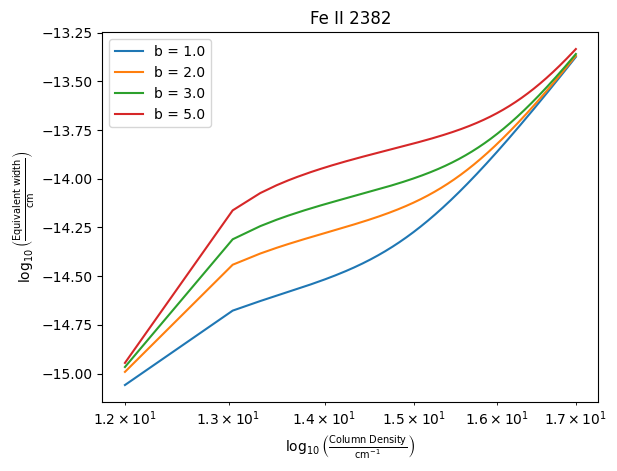

In [101]:
counter = 0
plot_curve_of_growth(N_Fe, b, width_F_1, f[counter], wavelength[counter], titles, counter)

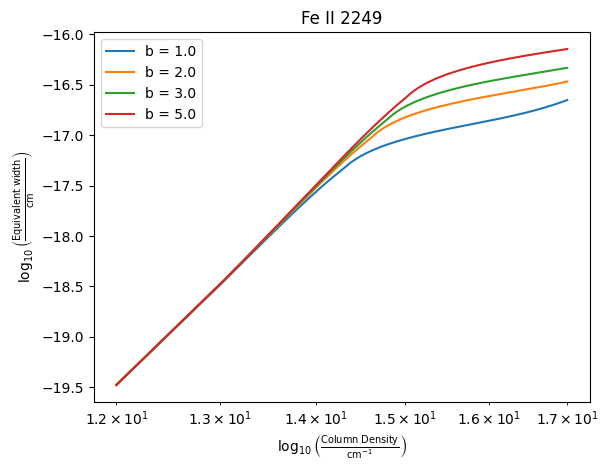

In [102]:
counter = 1
plot_curve_of_growth(N_Fe, b, width_F_2, f[counter], wavelength[counter], titles, counter)

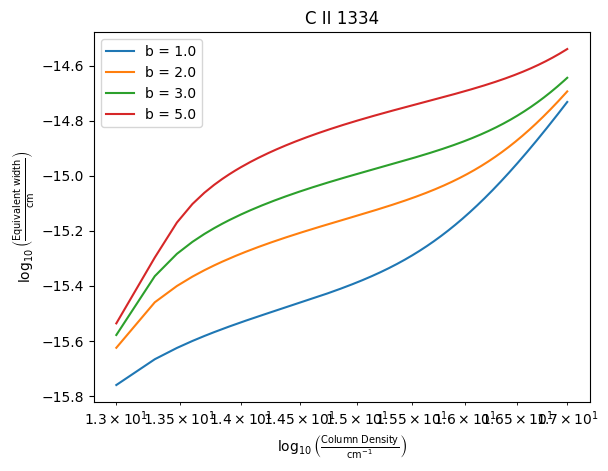

In [103]:
counter = 2
plot_curve_of_growth(N_C, b, width_C, f[counter], wavelength[counter], titles, counter)